# Loop 3 Analysis
Analyze the results from `experiments/003_infinite_loop/submission.csv`.
Goal: Understand the distribution of scores per N and identify bottlenecks.

Mean Score Contribution: 0.5911544111284887
Total Score: 118.23088222569775
Top 10 Worst N (Highest s^2/n):
       n     score
199  200  0.704796
197  198  0.698120
198  199  0.697399
196  197  0.694350
195  196  0.691600
190  191  0.675532
194  195  0.673973
191  192  0.673950
193  194  0.673296
188  189  0.672516
Top 10 Best N (Lowest s^2/n):
     n     score
3    4  0.430458
2    3  0.434766
4    5  0.450684
1    2  0.450834
11  12  0.454704
8    9  0.456949
5    6  0.457407
13  14  0.462858
7    8  0.473602
6    7  0.476441


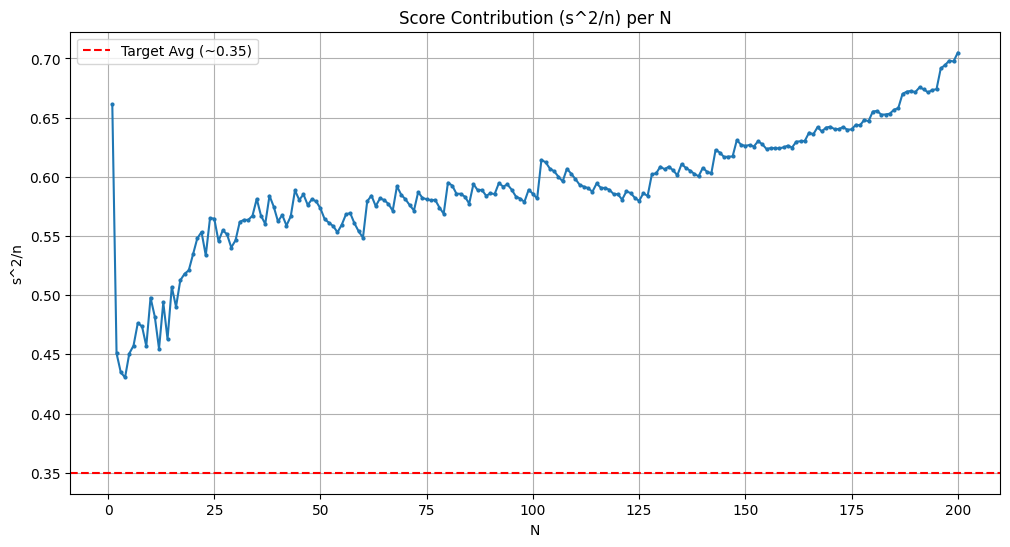

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import affinity

# Load submission
sub_path = 'experiments/003_infinite_loop/submission.csv'
df = pd.read_csv(sub_path)

def get_score_per_n(df):
    scores = []
    for n in range(1, 201):
        group = df[df['id'].str.startswith(f'{n:03d}_')]
        if group.empty:
            scores.append(0)
            continue
            
        # Calculate bounding box
        # Note: coordinates are strings 'sX.Y', need to parse
        xs = []
        ys = []
        for _, row in group.iterrows():
            # Parse tree polygon to get exact bounds? 
            # Or just use center + max radius approximation?
            # The metric uses the exact bounding box of the polygons.
            # Let's reconstruct polygons to be precise.
            
            # Tree definition (copied from run_loop.ipynb)
            scale_factor = 1
            center_x = float(row['x'].replace('s', ''))
            center_y = float(row['y'].replace('s', ''))
            angle = float(row['deg'].replace('s', ''))
            
            # Simplified: we just need the extent.
            # But trees have size. 
            # Let's use the ChristmasTree class logic if possible, or just approximate.
            # Approximation: The tree fits in a box.
            # Actually, let's just use the provided `score_and_validate` logic if I can copy it.
            # Or just re-implement the polygon construction.
            
            # Re-implement polygon construction for accuracy
            trunk_w = 0.15; trunk_h = 0.2
            base_w = 0.7; mid_w = 0.4; top_w = 0.25
            tip_y = 0.8; tier_1_y = 0.5; tier_2_y = 0.25
            base_y = 0.0; trunk_bottom_y = -trunk_h
            
            initial_polygon = Polygon([
                (0.0, tip_y),
                (top_w / 2, tier_1_y),
                (top_w / 4, tier_1_y),
                (mid_w / 2, tier_2_y),
                (mid_w / 4, tier_2_y),
                (base_w / 2, base_y),
                (trunk_w / 2, base_y),
                (trunk_w / 2, trunk_bottom_y),
                (-(trunk_w / 2), trunk_bottom_y),
                (-(trunk_w / 2), base_y),
                (-(base_w / 2), base_y),
                (-(mid_w / 4), tier_2_y),
                (-(mid_w / 2), tier_2_y),
                (-(top_w / 4), tier_1_y),
                (-(top_w / 2), tier_1_y),
            ])
            
            rotated = affinity.rotate(initial_polygon, angle, origin=(0, 0))
            translated = affinity.translate(rotated, xoff=center_x, yoff=center_y)
            
            min_x, min_y, max_x, max_y = translated.bounds
            xs.extend([min_x, max_x])
            ys.extend([min_y, max_y])
            
        if not xs:
            scores.append(0)
            continue
            
        side = max(max(xs) - min(xs), max(ys) - min(ys))
        scores.append(side**2 / n)
        
    return scores

scores = get_score_per_n(df)
n_values = list(range(1, 201))

plt.figure(figsize=(12, 6))
plt.plot(n_values, scores, marker='o', linestyle='-', markersize=2)
plt.title('Score Contribution (s^2/n) per N')
plt.xlabel('N')
plt.ylabel('s^2/n')
plt.grid(True)
plt.axhline(y=0.35, color='r', linestyle='--', label='Target Avg (~0.35)')
plt.legend()
plt.savefig('score_per_n.png')
print(f"Mean Score Contribution: {np.mean(scores)}")
print(f"Total Score: {sum(scores)}")

# Identify worst offenders
df_scores = pd.DataFrame({'n': n_values, 'score': scores})
print("Top 10 Worst N (Highest s^2/n):")
print(df_scores.sort_values('score', ascending=False).head(10))

print("Top 10 Best N (Lowest s^2/n):")
print(df_scores.sort_values('score', ascending=True).head(10))
